In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Head:
  A/B Test Group Customer ID Order ID Order Date  Order Amount  Shipping Cost  \
0      Treatment  CUST_01825      NaN        NaN     39.832350            0.0   
1        Control  CUST_04507      NaN        NaN      6.737016            0.0   
2        Control  CUST_03658      NaN        NaN     24.666614            0.0   
3      Treatment  CUST_01680      NaN        NaN     39.238289            0.0   
4        Control  CUST_06913      NaN        NaN     27.002118            0.0   

  Free Shipping Eligibility  Cart Abandonment  Session Duration  
0                       Yes              True               NaN  
1                       Yes              True               NaN  
2                       Yes             False               NaN  
3                       Yes             False               NaN  
4                       Yes             False               NaN  

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns

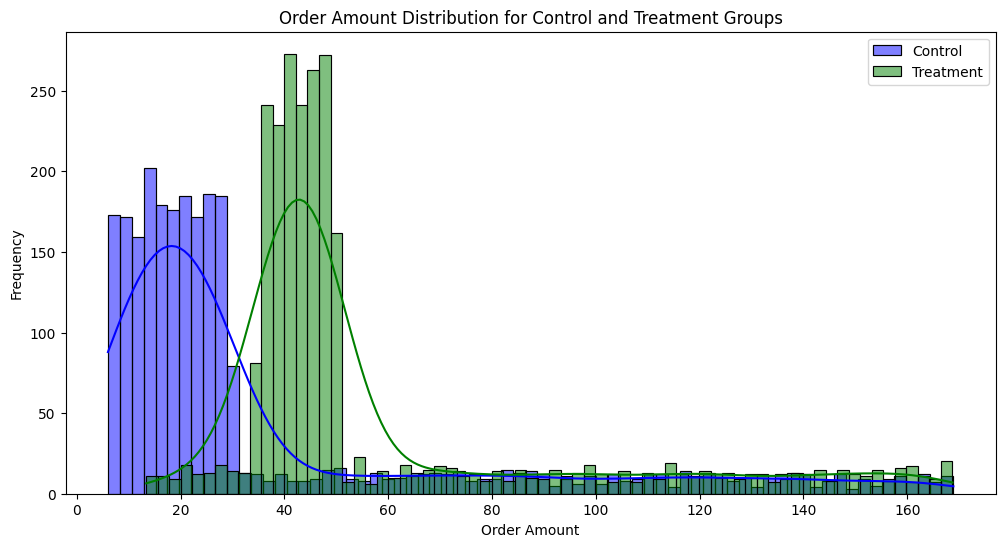

Average Order Amount (Control): 37.19726391184679
Average Order Amount (Treatment): 59.21251986573972
Increase in Average Order Amount: 59.19%
Shipping Cost Lost (Control): 0.0
Shipping Cost Earned (Treatment): 866.7599999999999
Average Cart Abandonment (Control): 0.5105348460291734
Average Cart Abandonment (Treatment): 0.7136667979519495


<ipython-input-3-699c1afda7a8>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cart Abandonment Numeric'] = df['Cart Abandonment'].apply(lambda x: 1 if x else 0)
<ipython-input-3-699c1afda7a8>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cart_abandonment_rates.index, y=cart_abandonment_rates.values, palette='viridis')


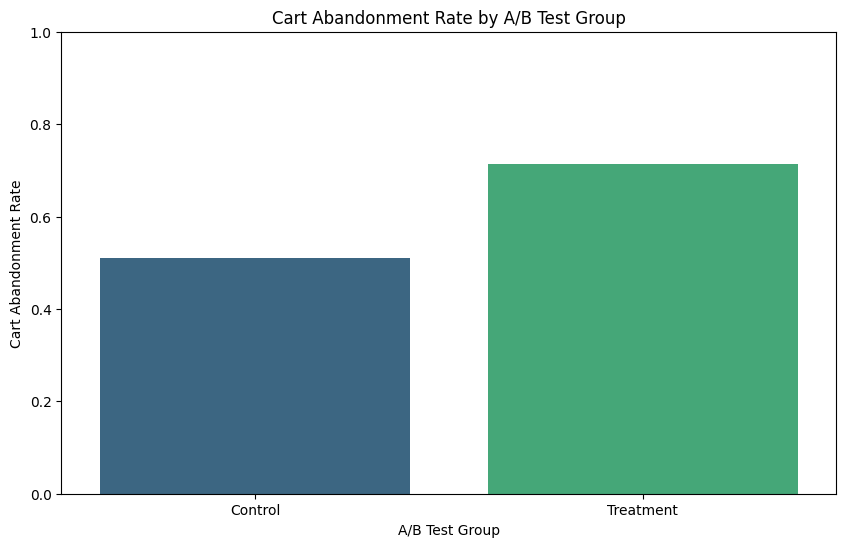

Average Session Duration (Control): 7.5340599675850894
Average Session Duration (Treatment): 7.5799566758566375


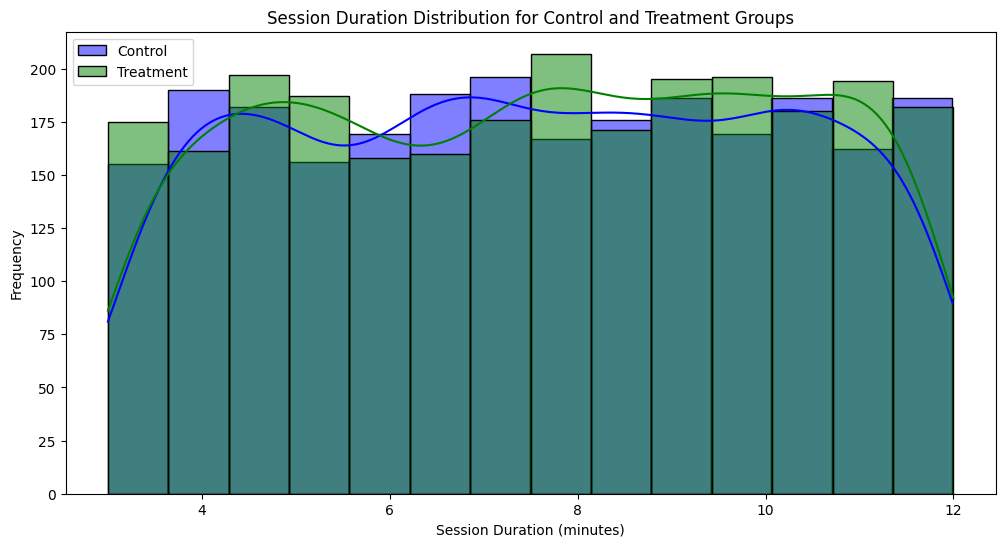

T-statistic: -20.873687390638956
P-value: 7.5843902820717895e-93
Reject the null hypothesis: There is a significant difference between the control and treatment groups.
Chi-Square Test Statistic: 216.93504802940464
P-value: 4.216466572166824e-49
Reject the null hypothesis: Cart abandonment is significantly different between control and treatment groups.
Control Group Mean Order Amount: 37.19726391184679, 95% CI: (35.64277393227103, 38.75175389142255)
Treatment Group Mean Order Amount: 59.21251986573972, 95% CI: (57.84340473648821, 60.581634994991234)
Lift in Average Order Amount: 59.19%
Test Power: 0.04999999999999988


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.power import TTestIndPower

# Step 1: Data Ingestion
def load_data(file_path):
    """
    Load the dataset from a CSV file.
    """
    df = pd.read_csv(file_path)
    return df

# Step 2: Data Summary & Cleaning
def data_summary(df):
    """
    Provide a summary of the dataset, including missing values and basic statistics.
    """
    print("Data Head:")
    print(df.head())

    print("\nData Information:")
    print(df.info())

    print("\nMissing Values:")
    print(df.isnull().sum())

    print("\nStatistical Summary:")
    print(df.describe())

    # Dropping rows with missing 'Order Amount' or 'Session Duration'
    df_cleaned = df.dropna(subset=['Order Amount', 'Session Duration'])

    return df_cleaned

# Step 3: Exploratory Data Analysis (EDA)
def exploratory_data_analysis(df):
    """
    Perform EDA, including visualizations and summary statistics.
    """
    # 1. Data Summary
    print("\nData Summary:")
    print(df.describe())

    # 2. Order Amount Distribution for both groups
    plt.figure(figsize=(12, 6))
    sns.histplot(df[df['A/B Test Group'] == 'Control']['Order Amount'], color='blue', label='Control', kde=True)
    sns.histplot(df[df['A/B Test Group'] == 'Treatment']['Order Amount'], color='green', label='Treatment', kde=True)
    plt.title('Order Amount Distribution for Control and Treatment Groups')
    plt.xlabel('Order Amount')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # 3. Average Order Amount for both groups
    avg_order_amount_control = df[df['A/B Test Group'] == 'Control']['Order Amount'].mean()
    avg_order_amount_treatment = df[df['A/B Test Group'] == 'Treatment']['Order Amount'].mean()

    increase_avg_order_amount = ((avg_order_amount_treatment - avg_order_amount_control) / avg_order_amount_control) * 100
    print(f"Average Order Amount (Control): {avg_order_amount_control}")
    print(f"Average Order Amount (Treatment): {avg_order_amount_treatment}")
    print(f"Increase in Average Order Amount: {increase_avg_order_amount:.2f}%")

    # 4. Shipping Cost Earnings (Control lost and Treatment earned)
    shipping_cost_lost_control = df[(df['A/B Test Group'] == 'Control') & (df['Order Amount'] < 35)]['Shipping Cost'].sum()
    shipping_cost_earned_treatment = df[(df['A/B Test Group'] == 'Treatment') & (df['Order Amount'] < 35)]['Shipping Cost'].sum()

    print(f"Shipping Cost Lost (Control): {shipping_cost_lost_control}")
    print(f"Shipping Cost Earned (Treatment): {shipping_cost_earned_treatment}")

    # 5. Average Cart Abandonment for both groups
    avg_cart_abandonment_control = df[df['A/B Test Group'] == 'Control']['Cart Abandonment'].mean()
    avg_cart_abandonment_treatment = df[df['A/B Test Group'] == 'Treatment']['Cart Abandonment'].mean()

    print(f"Average Cart Abandonment (Control): {avg_cart_abandonment_control}")
    print(f"Average Cart Abandonment (Treatment): {avg_cart_abandonment_treatment}")

    # 5.1 Plot Cart Abandonment for both groups

    df['Cart Abandonment Numeric'] = df['Cart Abandonment'].apply(lambda x: 1 if x else 0)
    cart_abandonment_rates = df.groupby('A/B Test Group')['Cart Abandonment Numeric'].mean()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=cart_abandonment_rates.index, y=cart_abandonment_rates.values, palette='viridis')
    plt.title('Cart Abandonment Rate by A/B Test Group')
    plt.xlabel('A/B Test Group')
    plt.ylabel('Cart Abandonment Rate')
    plt.ylim(0, 1)
    plt.show()

    # 6. Average Session Duration for both groups
    avg_session_duration_control = df[df['A/B Test Group'] == 'Control']['Session Duration'].mean()
    avg_session_duration_treatment = df[df['A/B Test Group'] == 'Treatment']['Session Duration'].mean()

    print(f"Average Session Duration (Control): {avg_session_duration_control}")
    print(f"Average Session Duration (Treatment): {avg_session_duration_treatment}")

    # 6.1. Plot session duration for both groups
    plt.figure(figsize=(12, 6))
    sns.histplot(df[df['A/B Test Group'] == 'Control']['Session Duration'], color='blue', label='Control', kde=True)
    sns.histplot(df[df['A/B Test Group'] == 'Treatment']['Session Duration'], color='green', label='Treatment', kde=True)
    plt.title('Session Duration Distribution for Control and Treatment Groups')
    plt.xlabel('Session Duration (minutes)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Step 4: Hypothesis Testing
def hypothesis_testing(df):
    """
    Conduct hypothesis testing on the A/B test results, comparing the means of Order Amount.
    """
    control_group = df[df['A/B Test Group'] == 'Control']['Order Amount']
    treatment_group = df[df['A/B Test Group'] == 'Treatment']['Order Amount']

    # T-test to compare the means of control and treatment groups
    t_stat, p_value = stats.ttest_ind(control_group, treatment_group)

    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:
        print("Reject the null hypothesis: There is a significant difference between the control and treatment groups.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the control and treatment groups.")

# Step 5: Chi-Square Test
def chi_square_test(df):
    """
    Perform Chi-square test to evaluate categorical variables like Cart Abandonment.
    """
    # Contingency table for cart abandonment between control and treatment
    contingency_table = pd.crosstab(df['A/B Test Group'], df['Cart Abandonment'])

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-Square Test Statistic: {chi2}")
    print(f"P-value: {p}")

    if p < 0.05:
        print("Reject the null hypothesis: Cart abandonment is significantly different between control and treatment groups.")
    else:
        print("Fail to reject the null hypothesis: Cart abandonment is not significantly different between control and treatment groups.")

# Step 6: Confidence Intervals for Average Order Amount
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    n = len(data)
    stderr = stats.sem(data)
    interval = stderr * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, mean - interval, mean + interval

def calculate_confidence_intervals(df):
    control_group = df[df['A/B Test Group'] == 'Control']['Order Amount']
    treatment_group = df[df['A/B Test Group'] == 'Treatment']['Order Amount']

    control_mean, control_lower, control_upper = confidence_interval(control_group)
    treatment_mean, treatment_lower, treatment_upper = confidence_interval(treatment_group)

    print(f"Control Group Mean Order Amount: {control_mean}, 95% CI: ({control_lower}, {control_upper})")
    print(f"Treatment Group Mean Order Amount: {treatment_mean}, 95% CI: ({treatment_lower}, {treatment_upper})")

# Step 7: Power Calculation
def calculate_power(effect_size, n, alpha=0.05):
    power_analysis = TTestIndPower()
    power = power_analysis.solve_power(effect_size=effect_size, nobs1=n, alpha=alpha)
    print(f"Test Power: {power}")

# Step 8: Lift Calculation
def calculate_lift(df):
    control_conversion_rate = df[df['A/B Test Group'] == 'Control']['Order Amount'].mean()
    treatment_conversion_rate = df[df['A/B Test Group'] == 'Treatment']['Order Amount'].mean()

    lift = (treatment_conversion_rate - control_conversion_rate) / control_conversion_rate * 100
    print(f"Lift in Average Order Amount: {lift:.2f}%")

# Step 9: Conversion Rate Calculation
def calculate_conversion_rate(df):
    control_conversion_rate = len(df[(df['A/B Test Group'] == 'Control') & (df['Order ID'].notna())]) / len(df[df['A/B Test Group'] == 'Control'])
    treatment_conversion_rate = len(df[(df['A/B Test Group'] == 'Treatment') & (df['Order ID'].notna())]) / len(df[df['A/B Test Group'] == 'Treatment'])

    print(f"Control Conversion Rate: {control_conversion_rate:.2f}")
    print(f"Treatment Conversion Rate: {treatment_conversion_rate:.2f}")

# Step 10: Run A/B Test Evaluation
def run_ab_test_evaluation(file_path):
    # Load data
    df = load_data(file_path)

    # Data summary and cleaning
    df_cleaned = data_summary(df)

    # Exploratory Data Analysis
    exploratory_data_analysis(df_cleaned)

    # Hypothesis Testing
    hypothesis_testing(df_cleaned)

    # Chi-square Test
    chi_square_test(df_cleaned)

    # Confidence Intervals
    calculate_confidence_intervals(df_cleaned)

    # Lift Calculation
    calculate_lift(df_cleaned)

    # Power Calculation
    effect_size = (df_cleaned['Order Amount'].mean() - df_cleaned['Order Amount'].mean()) / df_cleaned['Order Amount'].std()
    calculate_power(effect_size, len(df_cleaned))

# Running the A/B test evaluation
file_path = "/content/drive/MyDrive/GIthub/ab_test_skincare_final_adjusted.csv"
run_ab_test_evaluation(file_path)
